In [1]:
!pip install kaggle

#Importing Libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_colwidth= 100

import random
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Model

import cv2
import shutil
import warnings
warnings.filterwarnings("ignore")

#Loading data from kaggle

In [3]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:10<00:00, 158MB/s]
100% 2.29G/2.29G [00:10<00:00, 236MB/s]


In [5]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

#Data preprocessing

In [9]:
train='/content/chest_xray/train'
val='/content/chest_xray/test'
test='/content/chest_xray/val'

In [10]:
# List to store image file paths
train_data_images = []

# Traverse through subdirectories in the source directory
for root, dirs, files in os.walk(train):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Filter image files
            # Get the full path of each image file
            file_path = os.path.join(root, file)
            train_data_images.append(file_path)

In [11]:
val_data_images = []

# Traverse through subdirectories in the source directory
for root, dirs, files in os.walk(val):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Filter image files
            # Get the full path of each image file
            file_path = os.path.join(root, file)
            val_data_images.append(file_path)

In [12]:
test_data_images = []

# Traverse through subdirectories in the source directory
for root, dirs, files in os.walk(test):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Filter image files
            # Get the full path of each image file
            file_path = os.path.join(root, file)
            test_data_images.append(file_path)

In [13]:
# Shuffle the image paths list
random.shuffle(train_data_images)
random.shuffle(test_data_images)
random.shuffle(val_data_images)

In [14]:
#lenght of train
print(len(train_data_images))
print(len(test_data_images))
print(len(val_data_images))

5216
16
624


In [15]:
train_data_images[:50]

['/content/chest_xray/train/NORMAL/NORMAL2-IM-0826-0001.jpeg',
 '/content/chest_xray/train/NORMAL/IM-0414-0001.jpeg',
 '/content/chest_xray/train/NORMAL/IM-0629-0001.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person1724_bacteria_4549.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person470_bacteria_1999.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-1330-0001.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person1504_virus_2614.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person1028_bacteria_2959.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-0814-0001.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person1482_virus_2573.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person445_virus_915.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-0449-0001.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person1122_virus_1847.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person1585_bacteria_4151.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person392_virus_782.jpeg',
 '/content/chest_xray/train/

In [16]:
train_data='/content/chest_xray/train'
val_data='/content/chest_xray/test'
test_data='/content/chest_xray/val'

In [17]:
img_size=(224,224)
batch_size=32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
Val_datagen = ImageDataGenerator(rescale=1./255)


# Load the images and labels from the directories
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = Val_datagen.flow_from_directory(
    val_data,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [18]:
# #make folder called train_data
os.mkdir('/content/train_data')
os.mkdir('/content/val_data')
os.mkdir('/content/test_data')

In [19]:
print(train_data)

/content/chest_xray/train


In [20]:
# Ensure the destination folder exists, if not, create it
os.makedirs(train_data, exist_ok=True)

# Loop over each image in the list and copy it to the destination folder
for image in train_data_images:
    if os.path.exists(image):  # Check if the image file exists in the current directory
        shutil.copy(image, train_data)
        print(f"Copied {image} to {train_data}")
    else:
        print(f"Image {image} not found!")

# List the files in the destination folder to verify
print("Files in train_data folder:", os.listdir(train_data))

Streaming output truncated to the last 5000 lines.
Copied /content/chest_xray/train/PNEUMONIA/person566_bacteria_2351.jpeg to /content/chest_xray/train
Copied /content/chest_xray/train/PNEUMONIA/person356_bacteria_1638.jpeg to /content/chest_xray/train
Copied /content/chest_xray/train/PNEUMONIA/person1142_virus_1892.jpeg to /content/chest_xray/train
Copied /content/chest_xray/train/PNEUMONIA/person371_virus_754.jpeg to /content/chest_xray/train
Copied /content/chest_xray/train/PNEUMONIA/person35_bacteria_181.jpeg to /content/chest_xray/train
Copied /content/chest_xray/train/PNEUMONIA/person1474_virus_2557.jpeg to /content/chest_xray/train
Copied /content/chest_xray/train/PNEUMONIA/person1599_bacteria_4200.jpeg to /content/chest_xray/train
Copied /content/chest_xray/train/PNEUMONIA/person466_bacteria_1983.jpeg to /content/chest_xray/train
Copied /content/chest_xray/train/NORMAL/IM-0700-0001.jpeg to /content/chest_xray/train
Copied /content/chest_xray/train/PNEUMONIA/person867_bacteria_2

In [21]:
len(os.listdir(train_data))

5218

In [22]:
# Ensure the destination folder exists, if not, create it
os.makedirs(val_data, exist_ok=True)

# Loop over each image in the list and copy it to the destination folder
for image in val_data_images:
    if os.path.exists(image):  # Check if the image file exists in the current directory
        shutil.copy(image, val_data)
        print(f"Copied {image} to {val_data}")
    else:
        print(f"Image {image} not found!")

# List the files in the destination folder to verify
print("Files in train_data folder:", os.listdir(val_data))

Copied /content/chest_xray/test/PNEUMONIA/person159_bacteria_747.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/NORMAL/NORMAL2-IM-0352-0001.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/PNEUMONIA/person1661_virus_2873.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/NORMAL/IM-0063-0001.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/PNEUMONIA/person158_bacteria_744.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/PNEUMONIA/person109_bacteria_528.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/PNEUMONIA/person78_bacteria_381.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/NORMAL/NORMAL2-IM-0337-0001.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/PNEUMONIA/person1669_virus_2885.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/NORMAL/NORMAL2-IM-0052-0001.jpeg to /content/chest_xray/test
Copied /content/chest_xray/test/NORMAL/NORMAL2-IM-0

In [23]:
# Ensure the destination folder exists, if not, create it
os.makedirs(test_data, exist_ok=True)

# Loop over each image in the list and copy it to the destination folder
for image in test_data_images:
    if os.path.exists(image):  # Check if the image file exists in the current directory
        shutil.copy(image, test_data)
        print(f"Copied {image} to {test_data}")
    else:
        print(f"Image {image} not found!")

# List the files in the destination folder to verify
print("Files in train_data folder:", os.listdir(test_data))

Copied /content/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg to /content/chest_xray/val
Copied /content/chest_xray/val/PNEUMONIA/person1

In [24]:
print(len(train_data_images))
print(len(val_data_images))
print(len(test_data_images))

5216
624
16


In [25]:
#train_data[:50]
len(os.listdir(train_data))

5218

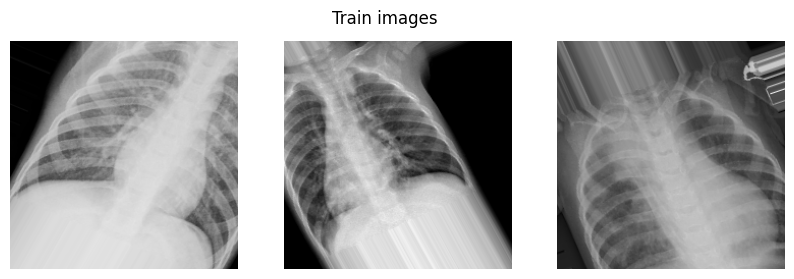

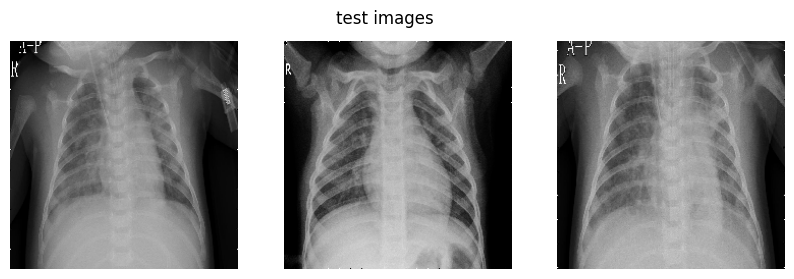

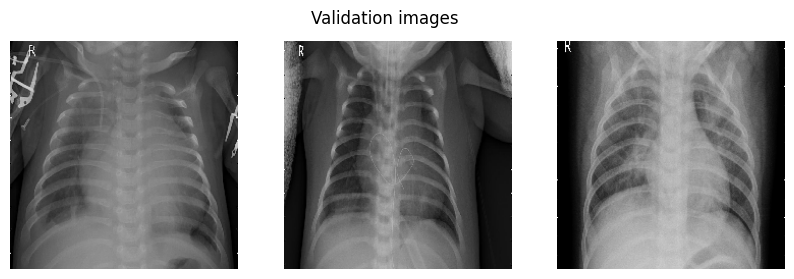

In [30]:
import matplotlib.pyplot as plt

def plot_images(generator,title):
    x,y=next(generator)
    fig , axes =plt.subplots(1,3,figsize=(10,3))
    fig.suptitle(title,fontsize=12)
    for i in range(3):
        axes[i].imshow(x[i])
        axes[i].axis('off')
    plt.show()
plot_images(train_generator ,'Train images')
plot_images(test_generator ,'test images')
plot_images(val_generator ,'Validation images')

#Building Model

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='CNN.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [32]:
Early_Stopping=EarlyStopping(monitor='val_loss',patience=5)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.00005)

In [47]:
IMG_SIZE=224

def get_model():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inputs], outputs=output)

    return model

In [34]:
model_get=get_model()
model_get.compile(loss='binary_crossentropy'
              , optimizer =optimizers.Adam(learning_rate=5e-5), metrics=['binary_accuracy'])

model_get.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │              

 Total params: 2,621,089 (10.00 MB)

 Trainable params: 2,620,865 (10.00 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
history_get=model_get.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[model_checkpoint_callback,Early_Stopping,reduce_lr]
)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
model_get.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │              

 Total params: 2,621,089 (10.00 MB)

 Trainable params: 2,620,865 (10.00 MB)

 Non-trainable params: 224 (896.00 B)

In [37]:
history=model_get.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[model_checkpoint_callback,Early_Stopping,reduce_lr]
)

Transfer learning

In [38]:
img_L=224
base_model = applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_L, img_L, 3),
    include_top=False)


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [41]:
from tensorflow.keras import layers, Model

img_L=224
base_model.trainable = False
def Pre_trained_model():
    # Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_L, img_L, 3))

    # Base model
    x = base_model(inputs, training=False)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Adding Batch Normalization
    x = layers.BatchNormalization()(x)

    # Increase Dropout to 0.3
    x = layers.Dropout(0.5)(x) ##0.5 perfect

    # Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inputs], outputs=output)

    return model


In [ ]:
# # Clear my sections
# clear_session()

In [40]:
model_pretrained = Pre_trained_model()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer =optimizers.Adam(learning_rate=5e-5), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,594,561 (223.52 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 58,331,904 (222.52 MB)

In [ ]:
##1 perfect
history_pretrained=model_pretrained.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[model_checkpoint_callback,Early_Stopping,reduce_lr]
)

In [42]:
##2
history_pretrained=model_pretrained.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[model_checkpoint_callback,Early_Stopping,reduce_lr]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 822ms/step - binary_accuracy: 0.6037 - loss: 0.8000 - val_binary_accuracy: 0.6683 - val_loss: 0.6425 - learning_rate: 5.0000e-05
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 166s 678ms/step - binary_accuracy: 0.8121 - loss: 0.4519 - val_binary_accuracy: 0.7949 - val_loss: 0.4593 - learning_rate: 5.0000e-05
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 672ms/step - binary_accuracy: 0.8570 - loss: 0.3704 - val_binary_accuracy: 0.8397 - val_loss: 0.3912 - learning_rate: 5.0000e-05
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 732ms/step - binary_accuracy: 0.8653 - loss: 0.3412 - val_binary_accuracy: 0.8446 - val_loss: 0.3584 - learning_rate: 5.0000e-05
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 705ms/step - binary_accuracy: 0.8837 - loss: 0.3171 - val_binary_accuracy: 0.8381 - val_loss: 0.3757 - learning_rate: 5.0000e-05
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 707ms/step - binary_accuracy: 0.9050 - loss: 0.2743 - val_binary_accuracy: 0.8590 - v

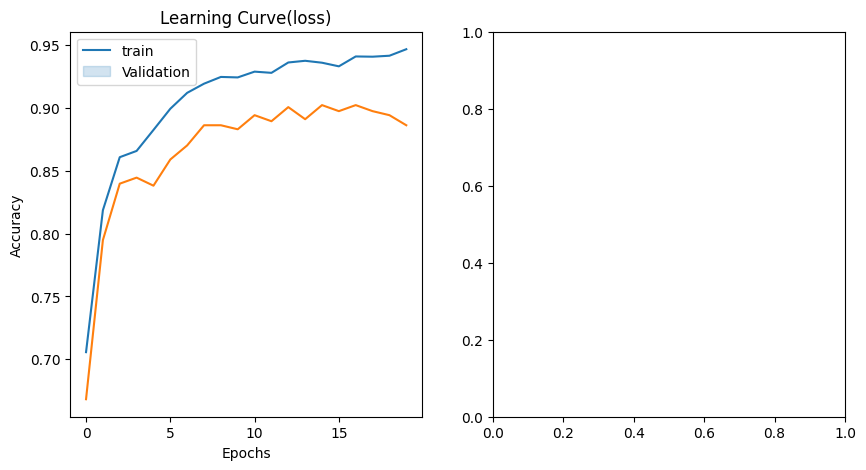

In [43]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.lineplot(x=history_pretrained.epoch,y=history_pretrained.history['binary_accuracy'],ax=ax[0],label='train')
sns.lineplot(x=history_pretrained.epoch,y=history_pretrained.history['val_binary_accuracy'],ax=ax[0],label='val')
ax[0].set_title('Learning Curve(loss)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train','Validation'], loc='best')
plt.show()

#Fune Tuning

In [45]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [ ]:
model_pretrained.compile(
                loss='binary_crossentropy'
              , optimizer =optimizers.Adam(learning_rate=0.000005)
              , metrics=['binary_accuracy'])

model_pretrained.summary()

In [ ]:
history_pretrained=model_pretrained.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[model_checkpoint_callback,Early_Stopping,reduce_lr]
)

In [46]:
for num_layer ,layer in enumerate(base_model.layers):
  print(num_layer,layer.name,layer.trainable)

0 input_layer_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv

In [ ]:
history_pretrained=model_pretrained.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[model_checkpoint_callback,Early_Stopping,reduce_lr]
)

In [ ]:

fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.lineplot(x=history_pretrained.epoch,y=history_pretrained.history['accuracy'],ax=ax[0],label='train')
sns.lineplot(x=history_pretrained.epoch,y=history_pretrained.history['val_accuracy'],ax=ax[0],label='val')
ax[0].set_title('Learning Curve(loss)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train','Validation'], loc='best')
plt.show()